Inverting vertical GPS displacements for terrestrial water storage. The GPS data used here is detrended.

Susheel Adusumilli, Scripps Institution of Oceanography

Last edit: May 10, 2020

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

First, we will load the Greens functions generated using make_greens_functions_disk_load.ipynb. We can swap this with a SPOTL/LOADDEF version later on!

In [2]:
greens = sio.loadmat('data/greens_matrix_025_deg_ALASKA.mat')
grid_cell = greens['grid_cell']
G = np.squeeze(greens['G'])
glon = np.squeeze(greens['glon'])
glat = np.squeeze(greens['glat'])
slon = np.squeeze(greens['slon'])
slat = np.squeeze(greens['slat'])

Then, we create a Laplacian matrix. For this, you need inversion_tools.py. By minimising the Laplacian of the terrestrial water storage distribution, we can control the amount of smoothing on our final TWS product.

In [3]:
from inversion_tools import create_laplacian
L = create_laplacian(glon,glat,grid_cell)
Ld = np.zeros_like(glat)

Load GPS data. These data were processed by Nick and have offsets removed. I then smoothed and resampled them to weekly timescales and removed the long-term trend.

In [4]:
gps_data = sio.loadmat('data/gps_verticals_ALASKA_filt.mat')
up = gps_data['up']
time = gps_data['time']

Set up GPS data and Green's functions for inversions. This means removing all NaNs in the GPS data and introducing the regularisation parameters lmbda1 and lmbda2. lmbda1 controls the smoothing through the Laplacian and lmbda2 controls the norm of the solution. 

In [5]:
lmbda1 = 0.01
lmbda2 = 0.01

up_inv = up[:,-1]
idx_data = np.invert(np.isnan(up_inv));
up_inv = up_inv[idx_data]
up_inv = np.concatenate((up_inv,lmbda1*Ld))
G_inv = G[idx_data,:]

The matrix used in our inversion is typically very sparse. Because of this, we are able to take advantage of some optimised matrix solvers. SciPy has several options for creating sparse matrices, each with its own benefits. For inversions, the csr_matrix approach is pretty useful. 

Solving our G.m = d matrix to double precision (1e-16) seems unnecesary given the uncertainty in our data. For speed, we use an interative (or "Krylov") solver – I picked lsmr here but there are other options, too. The maximum-norm constraint is directly applied within the solver: see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsmr.html for more details.

The default tolerences for convergence are more than sufficient here. I strongly discourage using a direct solver (like LU or SVD) for this application.

In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsmr
G_inv = csr_matrix(np.concatenate((G_inv,lmbda1*L)))
m, istop, itn, normr = lsmr(G_inv, up_inv, damp=lmbda2)[:4]

Finally, let's see what the outputs look like!

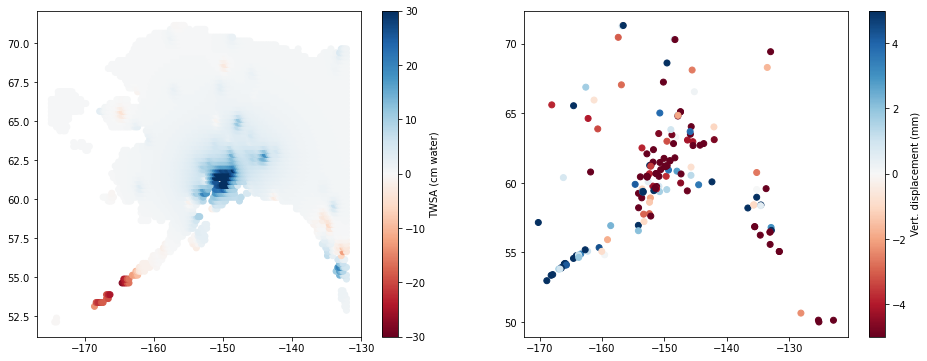

In [7]:
idx_nan = np.squeeze(np.where(np.sum(abs(L),1)<1));
m[idx_nan] = np.nan;

plt.figure(figsize = (16,6))
plt.subplot(122)
plt.scatter(slon,slat,c=up[:,-1]*1000, cmap='RdBu', vmin=-5, vmax=5)
cbar = plt.colorbar();
cbar.set_label("Vert. displacement (mm)")

plt.subplot(121)
plt.scatter(glon,glat,c=m*100, cmap='RdBu', vmin=-30, vmax=30)
cbar = plt.colorbar();
cbar.set_label("TWSA (cm water)")